## Validate observed vs. simulated yield

In [74]:
import os
import yaml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import Purples_9
from palettable.colorbrewer.sequential import YlGn_8
from palettable.cmocean.sequential import Tempo_10

from ideotype.nass_process import read_nass, summarize_nass
from ideotype.data_process import read_sims, read_data, parse_mature
from ideotype import DATA_PATH

In [102]:
# Read in site-years
df_siteyears = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/siteyears_filtered_nifa.csv',
                           dtype={'site':str})

In [103]:
# Read in NASS data
df_nass = read_nass()
df_nass = df_nass.query('year>=1961 & year<=2005')
df_nass_summary = summarize_nass()
df_nass_summary.head()

,state_id,county_id,lat,lon,area,yield,perct_irri
0,1.0,1.0,32.462991,-86.709691,6758.2607,3.041016,2.112183
1,1.0,3.0,30.787262,-87.712913,19748.6900,4.867478,8.510410
2,1.0,5.0,31.870087,-85.383129,11452.6210,3.540944,4.945534
3,1.0,7.0,33.072877,-87.112698,2092.2280,2.303269,0.624115
4,1.0,9.0,33.988350,-86.613622,10064.5470,4.070473,0.940536


In [104]:
# Read in stations info
fpaths_wea = os.path.join(DATA_PATH, 'files', 'filepaths_wea.yml')
with open(fpaths_wea) as pfile:
    dict_fpaths = yaml.safe_load(pfile)

# Read in info on conversion between WBAN & USAF id numbering system
fpath_stations_info = os.path.join(DATA_PATH,
                                   *dict_fpaths['stations_info'])
df_stations = pd.read_csv(fpath_stations_info, dtype={'USAF': str})

In [105]:
df_sites = df_stations[df_stations.USAF.isin(df_siteyears.site)][['USAF', 'NSRDB_LAT (dd)','NSRDB_LON(dd)']]
df_sites.columns = ['site', 'lat', 'lon']
df_sites.head()

,site,lat,lon
152,722060,30.500,-81.700
158,722070,32.117,-81.200
160,722080,32.900,-80.033
177,722140,30.380,-84.370
183,722170,32.683,-83.650


In [106]:
nass_yields = []

for item in np.arange(df_sites.shape[0]):
    lat = df_sites.iloc[item]['lat']
    lon = df_sites.iloc[item]['lon']
    
    dist = list(enumerate(
        np.sqrt((lat - df_nass_summary.lat)**2 + (lon - (df_nass_summary.lon))**2)))
    df_dist = pd.DataFrame(dist, columns=['rownum', 'distance'])
    rows = list(df_dist.nsmallest(15, 'distance').rownum)
    nass_yield = round(df_nass_summary.iloc[rows]['yield'].mean(),2)
    nass_yields.append(nass_yield)

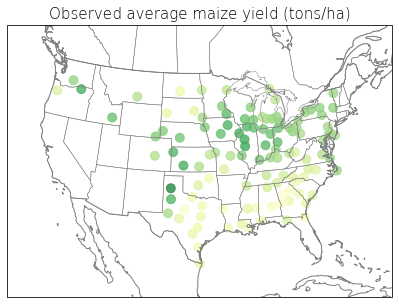

In [107]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))

ax.set_extent([-123,-72,19,53])
ax.scatter(df_sites.lon, df_sites.lat, 
           transform=ccrs.PlateCarree(),
           c=nass_yields, s=80,
           cmap=YlGn_8.mpl_colormap,
           alpha=0.8, vmin=2, vmax=10)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
ax.set_title('Observed average maize yield (tons/ha)', fontsize=15, fontweight='light')

fig.subplots_adjust(wspace=0.1, hspace=-0.8)

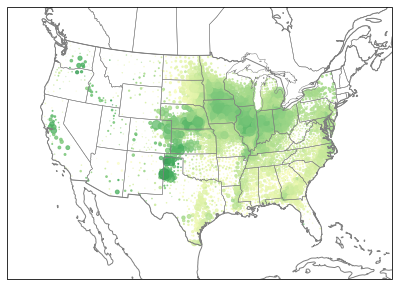

In [16]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
                     central_latitude=39.5, central_longitude=-98.35))

ax.set_extent([-123,-72,19,53])
ax.scatter(df_nass_summary.lon, df_nass_summary.lat, 
           transform=ccrs.PlateCarree(),
           c=df_nass_summary['yield']*2.47,
           s=df_nass_summary['area']/1000,
           cmap=YlGn_8.mpl_colormap, alpha=0.8)

ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

fig.subplots_adjust(wspace=0.1, hspace=-0.8)